## Setup

#### Packages


In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [214]:
data_path = "../data/raw/houses_Madrid.csv"
data = pd.read_csv(data_path,index_col = 0)
data.head()

,id,title,subtitle,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,latitude,...,energy_certificate,has_parking,has_private_parking,has_public_parking,is_parking_included_in_price,parking_price,is_orientation_north,is_orientation_west,is_orientation_south,is_orientation_east
0,21742,"Piso en venta en calle de Godella, 64","San Cristóbal, Madrid",64.0,60.0,2,1.0,NaN,NaN,NaN,...,D,False,NaN,NaN,NaN,NaN,False,True,False,False
1,21741,Piso en venta en calle de la del Manojo de Rosas,"Los Ángeles, Madrid",70.0,NaN,3,1.0,NaN,NaN,NaN,...,en trámite,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21740,"Piso en venta en calle del Talco, 68","San Andrés, Madrid",94.0,54.0,2,2.0,NaN,NaN,NaN,...,no indicado,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21739,Piso en venta en calle Pedro Jiménez,"San Andrés, Madrid",64.0,NaN,2,1.0,NaN,NaN,NaN,...,en trámite,False,NaN,NaN,NaN,NaN,False,False,True,False
4,21738,Piso en venta en carretera de Villaverde a Val...,"Los Rosales, Madrid",108.0,90.0,2,2.0,NaN,NaN,NaN,...,en trámite,True,NaN,NaN,True,0.0,True,True,True,True


In [215]:
data.shape

(21742, 57)

In [216]:
# check for full blank columns and drop them
blank_columns = data.columns[data.isnull().all()]

if blank_columns.empty:
    print("No columns with all missing values found.")
else:
    print("Columns with all missing values :")
    print(blank_columns)

data = data.drop(columns=blank_columns) #drop blank columns

Columns with all missing values :
Index(['latitude', 'longitude', 'portal', 'door', 'rent_price_by_area',
       'are_pets_allowed', 'is_furnished', 'is_kitchen_equipped',
       'has_private_parking', 'has_public_parking'],
      dtype='object')


In [217]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21742 entries, 0 to 21741
Data columns (total 47 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            21742 non-null  int64  
 1   title                         21742 non-null  object 
 2   subtitle                      21742 non-null  object 
 3   sq_mt_built                   21616 non-null  float64
 4   sq_mt_useful                  8228 non-null   float64
 5   n_rooms                       21742 non-null  int64  
 6   n_bathrooms                   21726 non-null  float64
 7   n_floors                      1437 non-null   float64
 8   sq_mt_allotment               1432 non-null   float64
 9   raw_address                   16277 non-null  object 
 10  is_exact_address_hidden       21742 non-null  bool   
 11  street_name                   15837 non-null  object 
 12  street_number                 6300 non-null   object 
 13  floor 

In [218]:
Columns_with_very_less_data = ['sq_mt_useful', 'n_floors', 'sq_mt_allotment', 'has_garden', 'street_name',
                               'has_pool', 'has_balcony', 'is_accessible', 'has_green_zones' ]
Columns_with_other_data = ['id', 'subtitle', 'raw_address', 'street_number','operation']
data = data.drop(columns = Columns_with_very_less_data)
data = data.drop(columns = Columns_with_other_data)

In [219]:
chop = data['neighborhood_id'].str.extract(r'Neighborhood (\d+): (.*?) \(.*\) - District (\d+): (.*)')
data['neighborhood']= chop[1]+ ' ' +chop[0]
data['District']= chop[3] + ' ' + chop[2]
data.drop(axis=1, columns=['neighborhood_id'], inplace=True)

In [220]:
data['HouseType'] = data['title'].apply(lambda x: x.split(' ')[0] if x[0] != ' ' else x.split(' ')[1])
data = data.drop(axis=1,columns=['house_type_id','title'])

In [221]:
# Check if columns have 'true' or 'false' as strings
has_true_false_columns = data.astype(str).apply(lambda x: x.str.contains(r'\btrue\b|\bfalse\b', case=False).any())

# Get column names where the condition is True
true_false_column_names = has_true_false_columns[has_true_false_columns].index.tolist()

print("Columns with 'true' or 'false' as strings:")
true_false_column_names

Columns with 'true' or 'false' as strings:


['is_exact_address_hidden',
 'is_floor_under',
 'is_rent_price_known',
 'is_buy_price_known',
 'is_renewal_needed',
 'is_new_development',
 'has_central_heating',
 'has_individual_heating',
 'has_ac',
 'has_fitted_wardrobes',
 'has_lift',
 'is_exterior',
 'has_terrace',
 'has_storage_room',
 'has_parking',
 'is_parking_included_in_price',
 'is_orientation_north',
 'is_orientation_west',
 'is_orientation_south',
 'is_orientation_east']

In [222]:
for column in true_false_column_names:
    data[column] = data[column].astype(str).str.lower().map({'true': 1, 'false': 0})

In [223]:
# Check for duplicates
duplicates = data.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

data = data.drop_duplicates()

Number of duplicate rows: 295


In [224]:
cols_to_fill_False = ['has_ac', 'has_fitted_wardrobes']

for col in cols_to_fill_False:
    data[col] = data[col].fillna('False')

In [225]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21447 entries, 0 to 21741
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   sq_mt_built                   21321 non-null  float64
 1   n_rooms                       21447 non-null  int64  
 2   n_bathrooms                   21431 non-null  float64
 3   is_exact_address_hidden       21447 non-null  int64  
 4   floor                         18856 non-null  object 
 5   is_floor_under                20284 non-null  float64
 6   rent_price                    21447 non-null  int64  
 7   is_rent_price_known           21447 non-null  int64  
 8   buy_price                     21447 non-null  int64  
 9   buy_price_by_area             21447 non-null  int64  
 10  is_buy_price_known            21447 non-null  int64  
 11  is_renewal_needed             21447 non-null  int64  
 12  is_new_development            20468 non-null  float64
 13  built_

In [226]:
for column in data.columns:
    print(f"Value counts for {column}:")
    print(data[column].value_counts())
    print()

Value counts for sq_mt_built:
sq_mt_built
70.0     490
60.0     481
80.0     421
65.0     375
90.0     352
        ... 
691.0      1
652.0      1
999.0      1
758.0      1
427.0      1
Name: count, Length: 678, dtype: int64

Value counts for n_rooms:
n_rooms
3     7121
2     5406
4     3319
1     2240
5     1734
6      709
0      435
7      259
8      111
9       54
10      26
11      10
12       9
13       6
24       3
15       2
16       1
18       1
14       1
Name: count, dtype: int64

Value counts for n_bathrooms:
n_bathrooms
1.0     8972
2.0     7272
3.0     2406
4.0     1162
5.0      861
6.0      416
7.0      182
8.0       94
9.0       37
10.0      13
11.0       7
14.0       3
13.0       3
12.0       1
15.0       1
16.0       1
Name: count, dtype: int64

Value counts for is_exact_address_hidden:
is_exact_address_hidden
1    14731
0     6716
Name: count, dtype: int64

Value counts for floor:
floor
1                       4348
2                       3507
3                       2

In [227]:
#cols_to_fill_Unknown = ['is_exterior', 'has_lift', 'has_individual_heating', 'has_central_heating', 'is_orientation_north', 'is_orientation_south', 'is_orientation_east', 'is_orientation_west']

#for col in cols_to_fill_Unknown:
#    data[col] = data[col].fillna('Unknown')

In [228]:
data.isna().sum()

sq_mt_built                       126
n_rooms                             0
n_bathrooms                        16
is_exact_address_hidden             0
floor                            2591
is_floor_under                   1163
rent_price                          0
is_rent_price_known                 0
buy_price                           0
buy_price_by_area                   0
is_buy_price_known                  0
is_renewal_needed                   0
is_new_development                979
built_year                      11601
has_central_heating              8075
has_individual_heating           8075
has_ac                          10398
has_fitted_wardrobes             8263
has_lift                         2364
is_exterior                      3016
has_terrace                     11997
has_storage_room                13837
energy_certificate                  0
has_parking                         0
is_parking_included_in_price    13815
parking_price                   13815
is_orientati

In [229]:
data = data.dropna(subset=['sq_mt_built', 'n_bathrooms'])

In [230]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21305 entries, 0 to 21741
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   sq_mt_built                   21305 non-null  float64
 1   n_rooms                       21305 non-null  int64  
 2   n_bathrooms                   21305 non-null  float64
 3   is_exact_address_hidden       21305 non-null  int64  
 4   floor                         18841 non-null  object 
 5   is_floor_under                20187 non-null  float64
 6   rent_price                    21305 non-null  int64  
 7   is_rent_price_known           21305 non-null  int64  
 8   buy_price                     21305 non-null  int64  
 9   buy_price_by_area             21305 non-null  int64  
 10  is_buy_price_known            21305 non-null  int64  
 11  is_renewal_needed             21305 non-null  int64  
 12  is_new_development            20331 non-null  float64
 13  built_

In [231]:
# Mapping dictionary from Spanish to English for energy_certificate column
spanish_to_english = {
    'en trámite': 'in process',
    'no indicado': 'not indicated',
    'inmueble exento': 'exempt property',
    'Piso' : 'Apartment',
    'Casa': 'House',
    'Ático': 'Penthouse',
    'Chalet': 'Chalet',
    'Dúplex': 'Duplex',
    'Estudio': 'Studio',
    'Finca': 'Farm'
}

# Replace values in the 'energy_certificate' column
data['energy_certificate'] = data['energy_certificate'].replace(spanish_to_english)

# Display the updated value counts
print(data['energy_certificate'].value_counts())


energy_certificate
in process         10672
not indicated       3624
E                   2652
D                   1102
G                    888
F                    669
A                    592
C                    571
B                    443
exempt property       92
Name: count, dtype: int64


### Data Visualizations

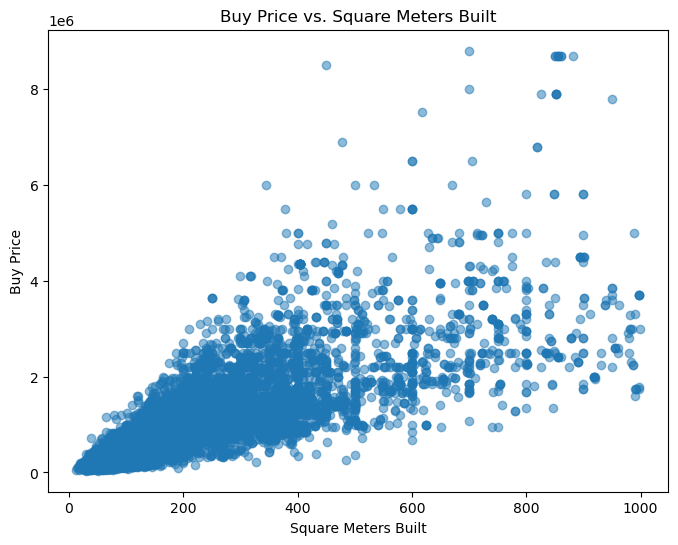

In [232]:
# Visualizations for 
plt.figure(figsize=(8, 6))
plt.scatter(data['sq_mt_built'], data['buy_price'], alpha=0.5)
plt.title('Buy Price vs. Square Meters Built')
plt.xlabel('Square Meters Built')
plt.ylabel('Buy Price')
plt.show()

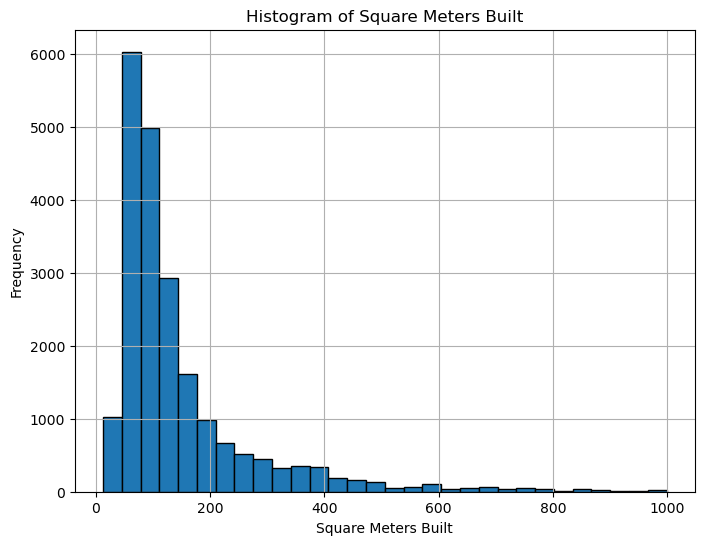

In [233]:
plt.figure(figsize=(8, 6))
plt.hist(data['sq_mt_built'], bins=30, edgecolor='black')
plt.title('Histogram of Square Meters Built')
plt.xlabel('Square Meters Built')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [234]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21305 entries, 0 to 21741
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   sq_mt_built                   21305 non-null  float64
 1   n_rooms                       21305 non-null  int64  
 2   n_bathrooms                   21305 non-null  float64
 3   is_exact_address_hidden       21305 non-null  int64  
 4   floor                         18841 non-null  object 
 5   is_floor_under                20187 non-null  float64
 6   rent_price                    21305 non-null  int64  
 7   is_rent_price_known           21305 non-null  int64  
 8   buy_price                     21305 non-null  int64  
 9   buy_price_by_area             21305 non-null  int64  
 10  is_buy_price_known            21305 non-null  int64  
 11  is_renewal_needed             21305 non-null  int64  
 12  is_new_development            20331 non-null  float64
 13  built_

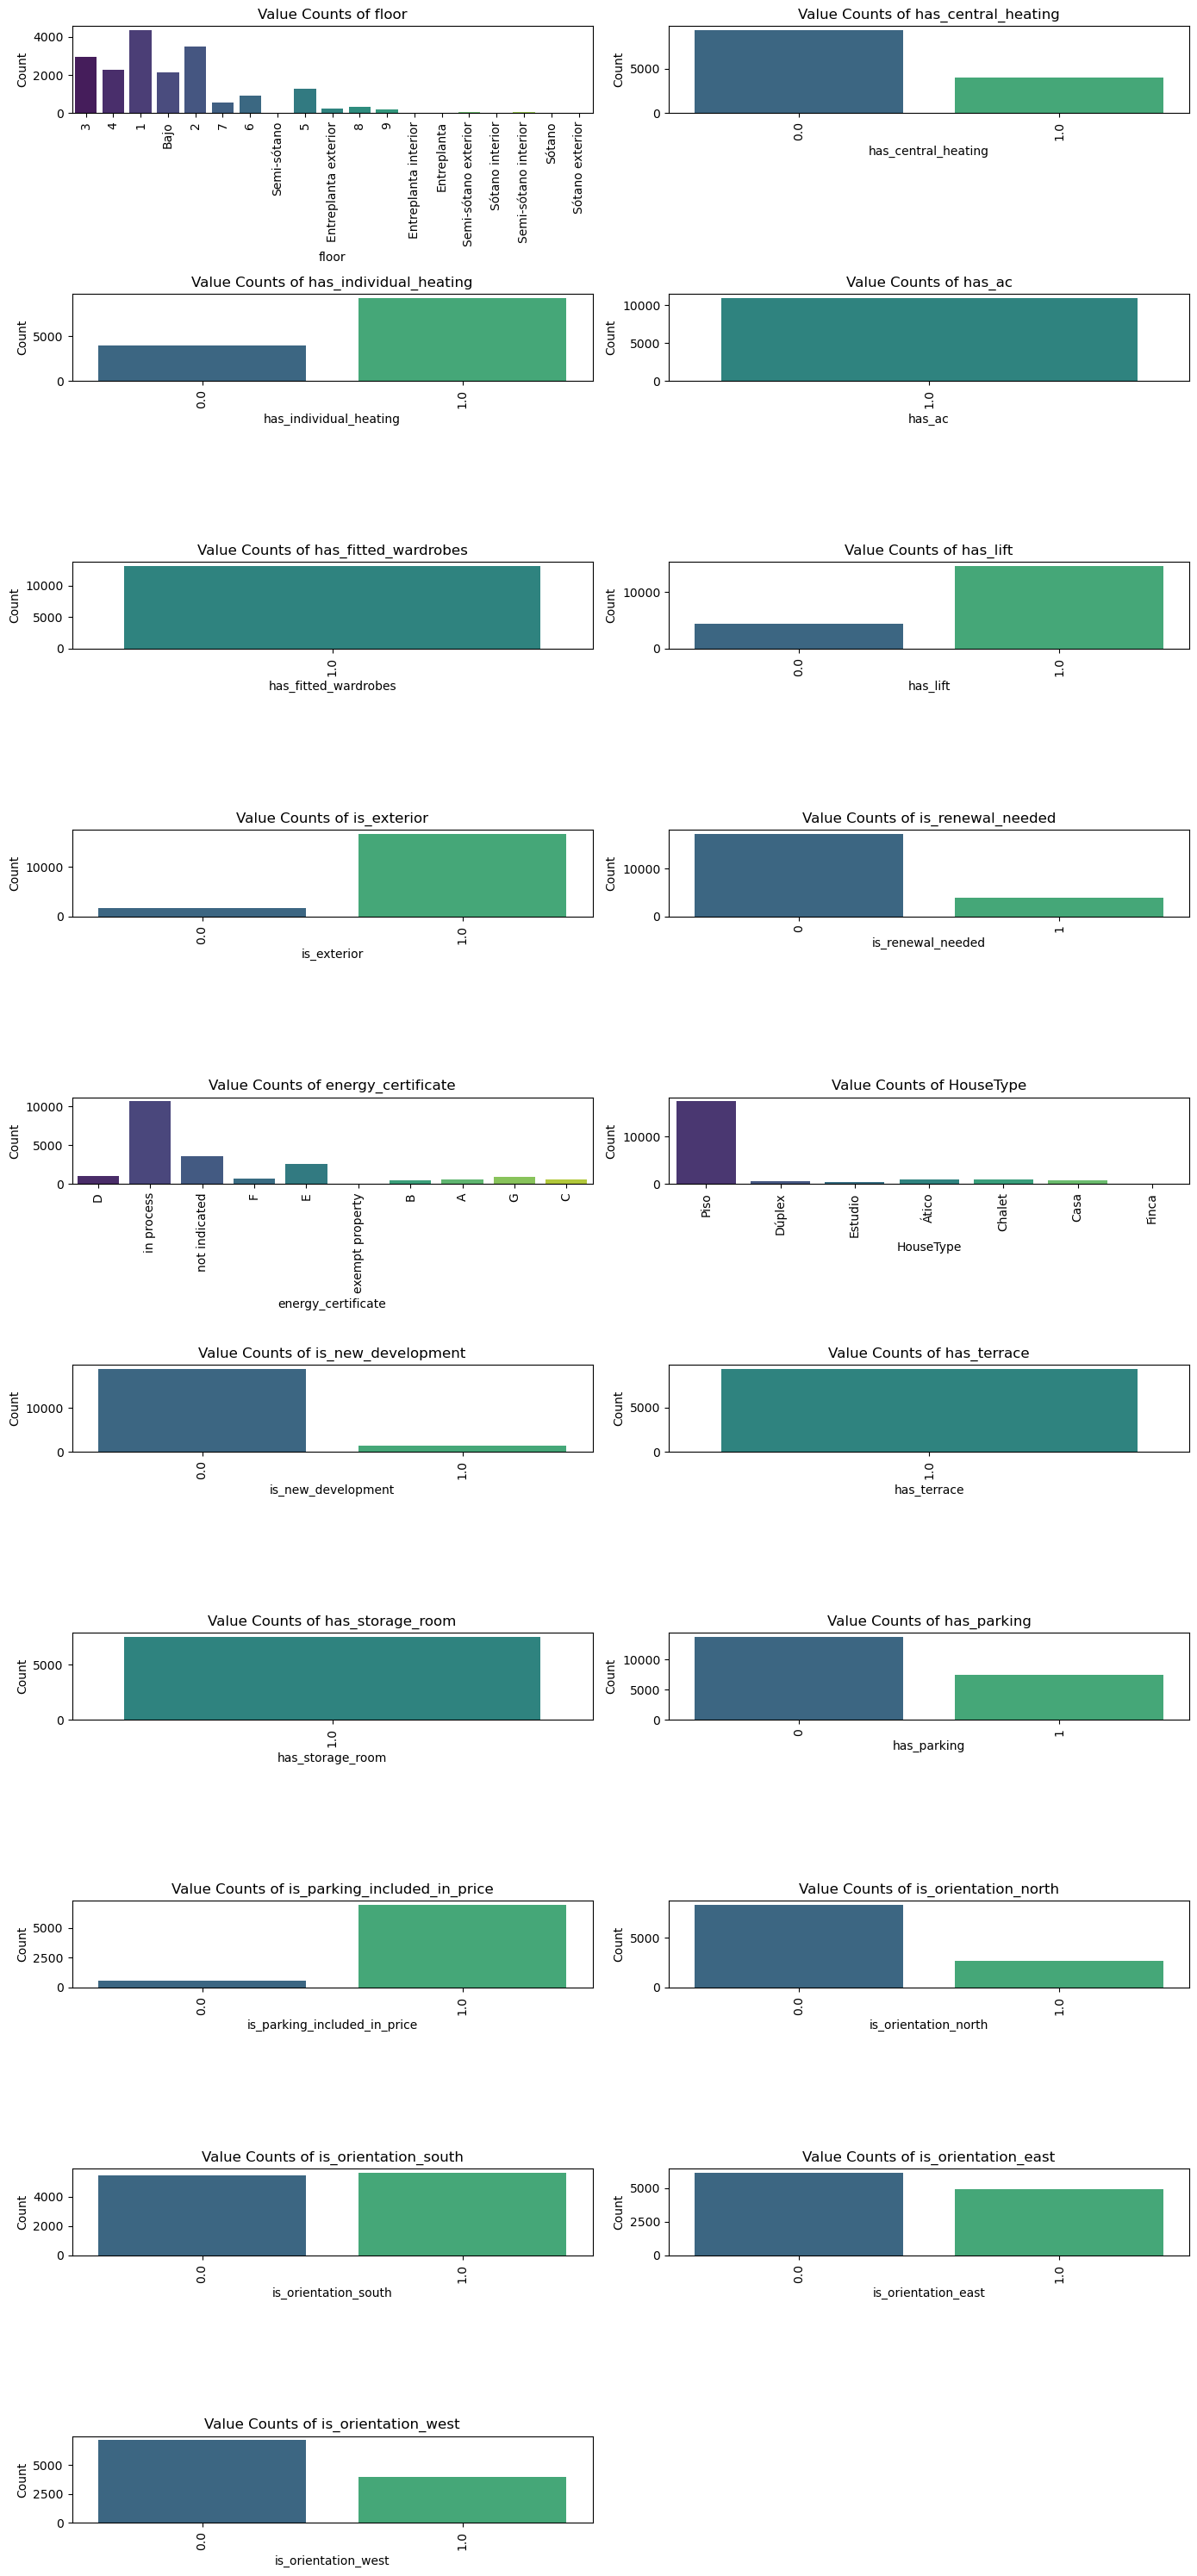

In [235]:
# Visualizations for categorical columns
# List of categorical columns for which to create bar plots
categorical_columns = ['floor', 'has_central_heating', 'has_individual_heating', 'has_ac', 
                       'has_fitted_wardrobes', 'has_lift', 'is_exterior', 'is_renewal_needed',
                       'energy_certificate', 'HouseType', 'is_new_development', 'has_terrace',
                        'has_storage_room', 'has_parking', 'is_parking_included_in_price',
                        'is_orientation_north', 'is_orientation_south', 'is_orientation_east',
                        'is_orientation_west']


# Create bar plots for each categorical column
# Calculate number of rows needed based on the number of columns (2 columns per row)
num_columns = 2
num_rows = (len(categorical_columns) + num_columns - 1) // num_columns  # Round up

# Create subplots with specified dimensions
fig, axes = plt.subplots(num_rows, num_columns, figsize=(14, 3*num_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through categorical columns and create count plots
for i, column in enumerate(categorical_columns):
    sns.countplot(data=data, x=column, palette='viridis', ax=axes[i])
    axes[i].set_title(f'Value Counts of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90)

# Hide any unused subplots
for j in range(len(categorical_columns), num_rows * num_columns):
    fig.delaxes(axes[j])

# Adjust layout
fig.tight_layout()
plt.show()

In [236]:
categorical_columns = ['floor', 'has_central_heating', 'has_individual_heating', 'has_ac', 
                       'has_fitted_wardrobes', 'has_lift', 'is_exterior', 'is_renewal_needed',
                       'energy_certificate', 'HouseType', 'is_new_development', 'has_terrace',
                        'has_storage_room', 'has_parking', 'is_parking_included_in_price',
                        'is_orientation_north', 'is_orientation_south', 'is_orientation_east',
                        'is_orientation_west']
# Convert all categorical variables to dummy variables
data_encoded = pd.get_dummies(data[categorical_columns], drop_first=True)

data_encoded.shape

(21305, 49)

In [237]:
columns_to_drop = categorical_columns + ['neighborhood', 'District']
data_dropped = data.drop(columns=columns_to_drop)

data_final = pd.concat([data_dropped, data_encoded], axis=1)

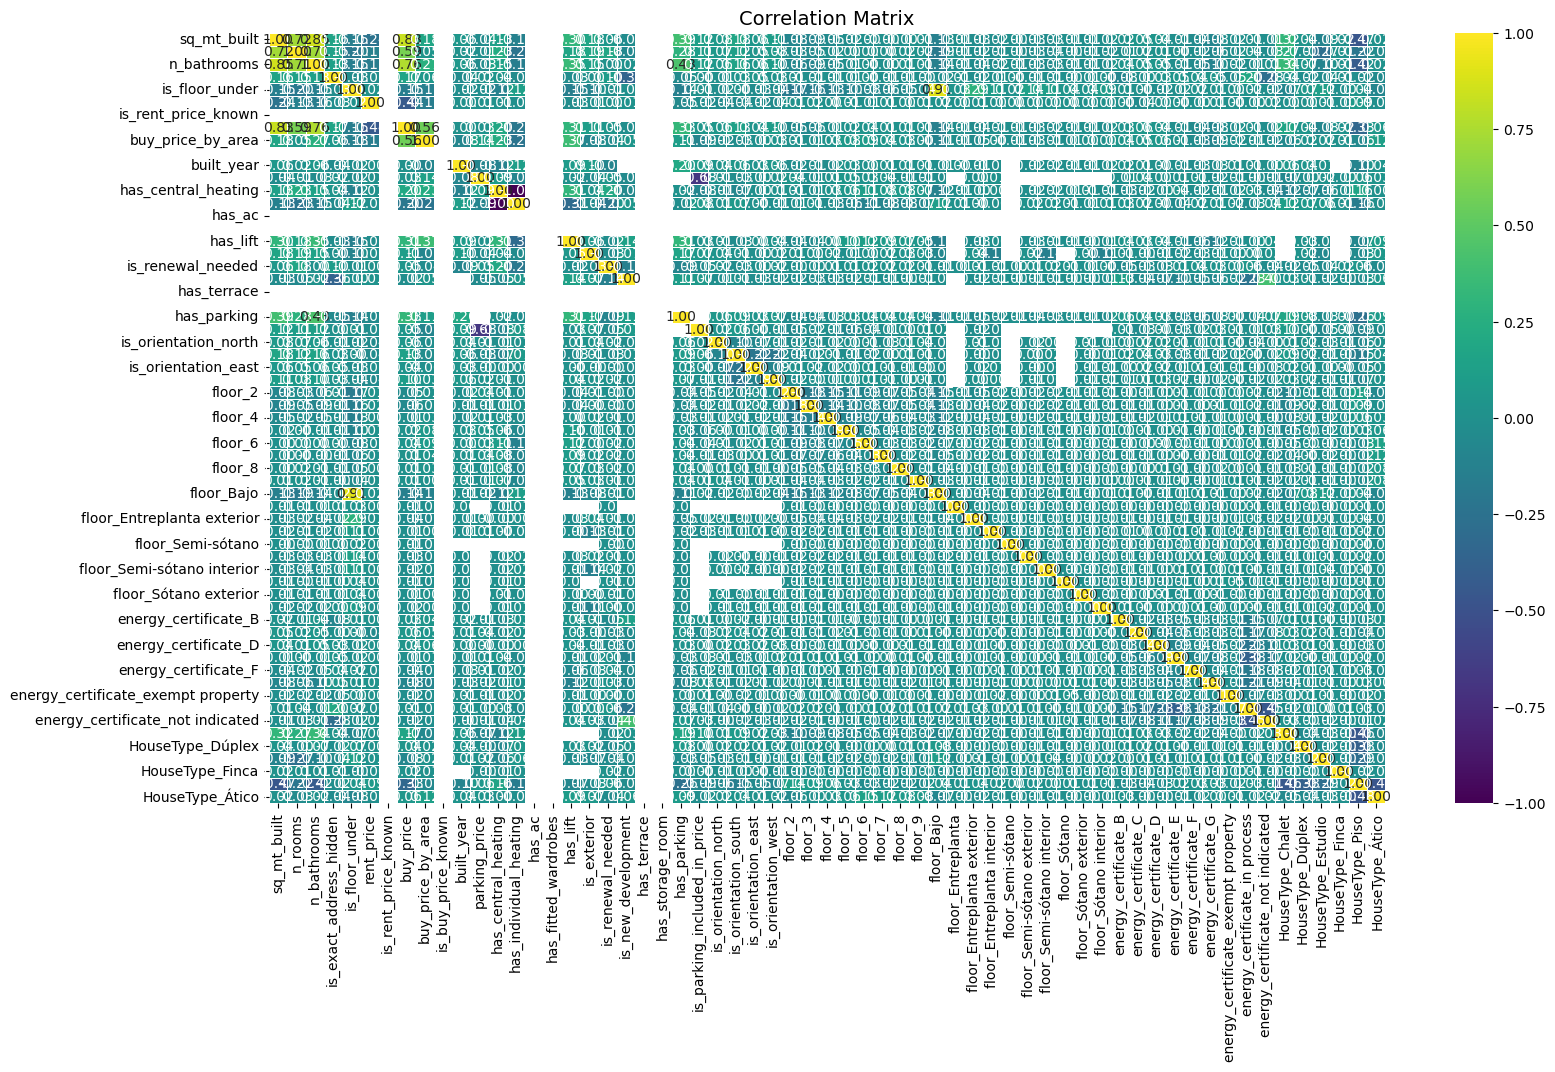

In [238]:
correlation_matrix = data_final.corr()

plt.figure(figsize=(18, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='viridis', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

In [241]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21305 entries, 0 to 21741
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   sq_mt_built                   21305 non-null  float64
 1   n_rooms                       21305 non-null  int64  
 2   n_bathrooms                   21305 non-null  float64
 3   is_exact_address_hidden       21305 non-null  int64  
 4   floor                         18841 non-null  object 
 5   is_floor_under                20187 non-null  float64
 6   rent_price                    21305 non-null  int64  
 7   is_rent_price_known           21305 non-null  int64  
 8   buy_price                     21305 non-null  int64  
 9   buy_price_by_area             21305 non-null  int64  
 10  is_buy_price_known            21305 non-null  int64  
 11  is_renewal_needed             21305 non-null  int64  
 12  is_new_development            20331 non-null  float64
 13  built_

In [240]:
file_path = '../data/processed/cleaned_data_Namrata_NAN.csv'

# Save cleaned DataFrame to CSV at the specified path
data.to_csv(file_path, index=False)